# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 43.10 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bn5423hp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bn5423hp
  Resolved https://github.com/albumentations-team/albumentations to commit 033ab261bb0a702f0350e48a8a07d7c9fecf420b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor(),
])

valid_augs = T.Compose([
    T.ToTensor(),
])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH,transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH,transform = valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


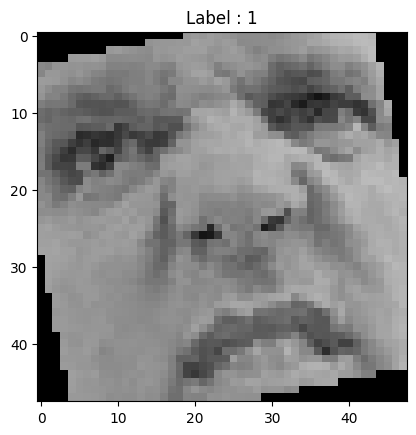

In [ ]:
image,label = trainset[4000]

plt.imshow(image.permute(1,2,0))
plt.title(f"Label : {label}")
plt.show()


# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images , labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [ ]:
import timm
from torch import nn

In [ ]:
class facenet(nn.Module):
    def __init__(self):
      super(facenet, self).__init__()

      self.eff_net = timm.create_model('efficientnet_b0', pretrained=True,num_classes=7)

    def forward(self, images, labels=None):
        logits = self.eff_net(images)

        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        return logits

In [ ]:
model = facenet()
model.to(DEVICE);

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader,desc="EPOCH" + "[TRAIN]" + str(current_epo+1) + "/" + str(EPOCHS))

  for t,data in enumerate(tk):
    images,labels = data
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits,labels)

    tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)),'acc' : '%6f' %float(total_acc/(t+1)),})

    return total_loss/len(dataloader),total_acc/len(dataloader)


In [ ]:
def eval_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader,desc="EPOCH" + "[VALID]" + str(current_epo+1) + "/" + str(EPOCHS))

  for t,data in enumerate(tk):
    images,labels = data
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits,loss = model(images,labels)


    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits,labels)

    tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)),'acc' : '%6f' %float(total_acc/(t+1)),})

    return total_loss/len(dataloader),total_acc/len(dataloader)


# Create Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)


In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss,train_acc = train_fn(model,trainloader,optimizer,i)
  valid_loss,valid_acc = eval_fn(model,validloader,i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss

EPOCH[TRAIN]1/15:   0%|          | 0/901 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
EPOCH[VALID]1/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=2.659051, acc=0.281250]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=2.327706, acc=0.281250]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=7.591231, acc=0.062500]


# Inference

In [ ]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None



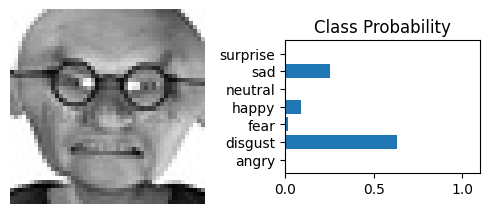

In [ ]:
image, label = validset[55]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)
